In [1]:
from app.rl.tictactoe.t3_test import T3Model, convert_inputs
from gym_tic_tac_toe.envs.tic_tac_toe_env import TicTacToeEnv, Pix
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
model = T3Model(8).double().to(device)

99: 18.19225128760262
199: 18.603870829035724
299: 19.11047521554423
399: 19.06541717675576
499: 18.610508271176496


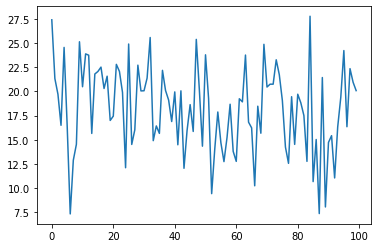

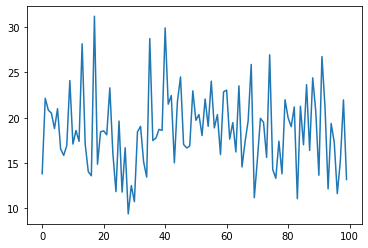

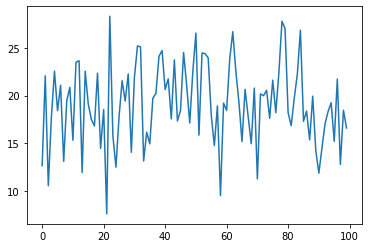

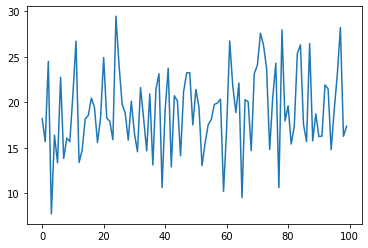

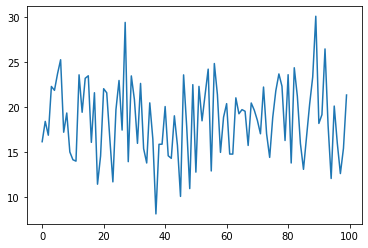

In [ ]:
def get_split_player_indices(size):
    # Random indices
    # me_idx_bool = torch.rand(size) > 0.5

    # First half
    me_idx_bool = torch.arange(size) > (size - 1) / 2

    opo_idx = torch.nonzero(torch.logical_not(me_idx_bool)).flatten(0)
    me_idx = torch.nonzero(me_idx_bool).flatten(0)
    return me_idx, opo_idx, me_idx_bool


def get_credits(t, gamma):
    credits = []
    prev_credit = 1
    for i in range(t):
        credits.append(prev_credit)
        prev_credit *= gamma
    return torch.tensor(list(reversed(credits))).double().to(device)


def get_returns(stats, gamma):
    total_t = len(stats)
    returns = []
    prev_return = 0
    for t in range(total_t):
        prev_return = stats[total_t - t -1][1] + (gamma * prev_return)
        returns.append(prev_return)
    return torch.tensor(list(reversed(returns))).double().to(device)


def get_loss(stats):
    loss = 0
    for i_env in range(len(stats)):
        returns = get_returns(stats[i_env], gamma=0.75)

        probs = torch.stack([stat[0] for stat in stats[i_env]])
        probs = torch.log(probs)

        credits = get_credits(len(stats[i_env]), gamma=0.75)

        loss += torch.sum(probs * credits * returns) / len(stats[i_env])
    return -1 * loss / len(stats)


def train():
    model.train()
    optim = torch.optim.Adam(model.parameters(), lr=1e-1)
    batch_size = 32
    envs = [TicTacToeEnv() for _ in range(batch_size)]
    losses = []

    for epoch in range(1000):
        # Before game starts

        me_idx, opo_idx, me_idx_bool = get_split_player_indices(batch_size)

        stats = [[] for _ in range(batch_size)]
        is_dones = [False for _ in range(batch_size)]
        _ = [env.reset() for env in envs]

        # Set current player to random
        for i in range(batch_size):
            envs[i].player = Pix.X if me_idx_bool[i] else Pix.O

        # Monte Carlo loop
        for i_step in range(15):
            legal_actions = [env.get_legal_actions() for env in envs]

            xs = [convert_inputs(envs[i].state, envs[i].player) for i in range(batch_size)]
            xs = torch.stack(xs).long().to(device)

            yh = model(xs)  # yh shape: (batch, 9)


            for i in range(batch_size):
                if not is_dones[i]:

                    # Is current player AI or other?
                    ai_player = Pix.X if me_idx_bool[i] else Pix.O
                    if envs[i].player == ai_player:
                        legal_probs = F.softmax(yh[i, legal_actions[i]], 0)
                        action_idx = int(torch.multinomial(legal_probs, 1).squeeze())

                        state, reward, is_done, info = envs[i].step(legal_actions[i][action_idx])

                        prob = legal_probs[action_idx]
                        stats[i].append([prob, reward])
                    else:
                        random_idx = int(torch.randint(low=0, high=len(legal_actions[i]), size=(1,))[0])
                        action = legal_actions[i][random_idx]

                        _, _, is_done, _ = envs[i].step(action)

                    is_dones[i] = is_done

            if all(is_dones):
                break

        loss = get_loss(stats)

        optim.zero_grad()
        loss.backward()
        optim.step()
        losses.append(loss.item())
        if (epoch + 1) % 100 == 0:
            print(f'{epoch}: {np.mean(losses)}')

            #if (epoch + 1) % 1000 == 0:
            plt.plot(losses)
            plt.show()

            losses = []

train()
